In [1]:
# 라이브러리 & 데이터 import

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습/10주차 강의/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습/10주차 강의/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# -----------------------------------------------------------------
# 🎯 여기에 정규화 코드 추가
# -----------------------------------------------------------------

# StandardScaler는 2D 입력을 기대하므로 (samples, features) 형태로 변환해야 합니다.
# (7352, 128, 9) -> (7352 * 128, 9) = (941056, 9)

# 1. 원본 3D 형태 저장
train_shape = trainX.shape
test_shape = testX.shape

# 2. 2D로 변환
trainX_2d = trainX.reshape(-1, train_shape[2])
testX_2d = testX.reshape(-1, test_shape[2])

# 3. StandardScaler 생성 및 'trainX_2d'에만 fit
scaler = StandardScaler()
scaler = scaler.fit(trainX_2d) # 👈 train 데이터로만 fit 합니다.

# 4. trainX와 testX를 transform
trainX_scaled_2d = scaler.transform(trainX_2d)
testX_scaled_2d = scaler.transform(testX_2d)

# 5. 다시 원래 3D 형태로 복원
trainX = trainX_scaled_2d.reshape(train_shape)
testX = testX_scaled_2d.reshape(test_shape)

print("\n데이터 정규화 완료!")
print(f"trainX mean: {trainX.mean():.4f}, std: {trainX.std():.4f}") # 평균 0, 표준편차 1에 가까워짐
print(f"testX mean: {testX.mean():.4f}, std: {testX.std():.4f}")
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-3472010578.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3472010578.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3472010578.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3472010578.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)

데이터 정규화 완료!
trainX mean: -0.0000, std: 1.0000
testX mean: -0.0072, std: 0.9534


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,498 (306.63 KB)

 Trainable params: 78,498 (306.63 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4816 - loss: 1.2548 - val_accuracy: 0.8838 - val_loss: 0.3551
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8575 - loss: 0.4133 - val_accuracy: 0.9198 - val_loss: 0.2005
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9360 - loss: 0.2022 - val_accuracy: 0.9429 - val_loss: 0.1494
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9455 - loss: 0.1502 - val_accuracy: 0.9443 - val_loss: 0.1341
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9441 - loss: 0.1537 - val_accuracy: 0.9443 - val_loss: 0.1390
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9478 - loss: 0.1408 - val_accuracy: 0.9375 - val_loss: 0.1323
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9426 - loss: 0.1525 - val_accuracy: 0.9415 - val_loss: 0.1574
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9490 - loss: 0.1442 - val_accuracy: 0.9463 - val_l

In [4]:
loss, accuracy = model.evaluate(testX, testy_one_hot, batch_size=64, verbose=1)

print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.3610

Test Loss: 0.2919
Test Accuracy: 0.9206


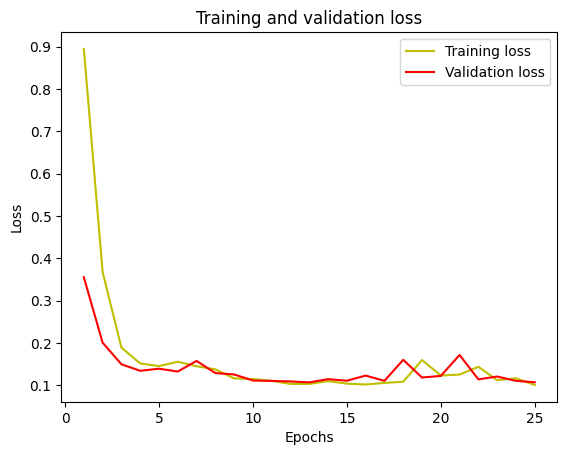

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

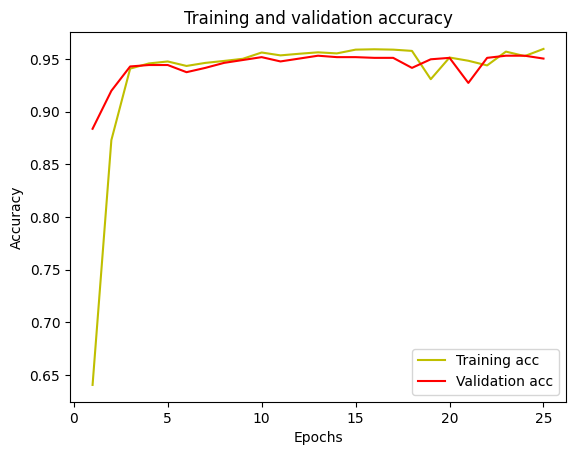

In [6]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()